Looking at Metrics and Plots Made From the Command Line
-------------------------------------------------------

- SDC: Last update 2024-03-23
- w_2024_10

### Links

- Plot Navigator : https://usdf-rsp.slac.stanford.edu/plot-navigator/dashboard_gen3
- Doc on pipelines : https://pipelines.lsst.io/v/daily/modules/lsst.analysis.tools/index.html
- Code on GitHub : https://github.com/lsst/analysis_tools

Following the getting started guide we have run a pipeline from the command line to produce the coadd quality core plots and metrics.

In [1]:
from lsst.analysis.tools.tasks.reconstructor import reconstructAnalysisTools
import lsst.daf.butler as dafButler
from lsst.analysis.tools.interfaces._task import _StandinPlotInfo

import numpy as np

In [2]:
skymap_sel = "latiss_v1"
instrument_sel = "LATISS"
tract_sel = 3864
patch_sel = 236 # or 237
band_sel = "g"
table_sel = "objectTable_tract"

# plotting range for visits
XLIM = (122.3,122.7)
YLIM = (-36.3,-36.05)

Let's read back in the data that we just made

In [3]:
#collection = "/sdf/group/rubin/u/sr525/coaddQualityCoreDemoRepo"
#collection ="LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553"
collection = "LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871"
repo = '/sdf/group/rubin/repo/oga/'
dataId = {"tract": tract_sel, "skymap": skymap_sel}
Butler = dafButler.Butler(repo)
skymap = Butler.get('skyMap', skymap=skymap_sel, collections=collection)

In [4]:
anaList = list(Butler.registry.queryDatasetTypes('*ana*'))
# Note: please ignore the Spectractor WARNING messages below, they are to be expected here.
for ana in anaList:
    print(ana)

DatasetType('analyzeSourceTableCore_config', {}, Config)
DatasetType('analyzeSourceTableCore_metadata', {band, instrument, detector, physical_filter, visit}, TaskMetadata)
DatasetType('analyzeSourceTableCore_log', {band, instrument, detector, physical_filter, visit}, ButlerLogRecords)
DatasetType('analyzeMatchedVisitCore_config', {}, Config)
DatasetType('analyzeSourceTableCoreDevel_config', {}, Config)
DatasetType('analyzeSourceTableCoreDevel_metadata', {band, instrument, physical_filter, visit}, TaskMetadata)
DatasetType('analyzeSourceTableCoreDevel_log', {band, instrument, physical_filter, visit}, ButlerLogRecords)
DatasetType('analyzeMatchedVisitQualityCore_config', {}, Config)
DatasetType('analyzeMatchedVisitQualityCore_metadata', {instrument, skymap, tract}, TaskMetadata)
DatasetType('analyzeMatchedVisitQualityCore_log', {instrument, skymap, tract}, ButlerLogRecords)
DatasetType('analyzeMatchedVisitCore_metadata', {instrument, skymap, tract}, TaskMetadata)
DatasetType('analyzeMatc

The reconstructor contains all of the plots/metrics that we just made, we specify the label and that gives us just the ones in that section of the pipeline.

In [5]:
taskState, inputData = reconstructAnalysisTools(Butler, 
                                                collection=collection,
                                                label="analyzeObjectTableCore",
                                                #label="analyszematchedVisitCore",
                                                #label="analyzeSourceTableCore",
                                                #label="analyzeMatchedVisitCore", 
                                                #label="analyzeObjectTableSurveyCore",
                                                dataId=dataId, 
                                                callback=None
)

Let's list the actions that were run

In [6]:
for action in taskState.atools:
    print(action.identity)

e1Diff
e2Diff
shapeSizeFractionalDiff
skyFluxStatisticMetric
skyObjectFlux
skyObjectSky
wPerpCModel
wPerpPSFP
xPerpCModel
xPerpPSFP


Now we can recreate them, we're going to pick one and look at it.

In [7]:
plotInfoDict = {"run": collection, "bands": band_sel, "tract": tract_sel, "tableName": table_sel}
#taskState.atools.rhoStatistics(inputData["data"], plotInfo=plotInfoDict, skymap="latiss_v1", band=band_sel)
taskState.atools.skyFluxStatisticMetric(inputData["data"], plotInfo=plotInfoDict, skymap=skymap, band=band_sel)

{'skyFluxStatisticMetric_g_medianSky': Measurement('g_medianSky', <Quantity -30.76893416 nJy>, notes={'g_medianSky.metric_tags': []}),
 'skyFluxStatisticMetric_g_meanSky': Measurement('g_meanSky', <Quantity -28.00802466 nJy>, notes={'g_meanSky.metric_tags': []}),
 'skyFluxStatisticMetric_g_stdevSky': Measurement('g_stdevSky', <Quantity 776.12917066 nJy>, notes={'g_stdevSky.metric_tags': []}),
 'skyFluxStatisticMetric_g_sigmaMADSky': Measurement('g_sigmaMADSky', <Quantity 597.83695123 nJy>, notes={'g_sigmaMADSky.metric_tags': []})}

In [8]:
taskState.atools.fieldNames

dict_keys(['e1Diff', 'e2Diff', 'shapeSizeFractionalDiff', 'skyFluxStatisticMetric', 'skyObjectFlux', 'skyObjectSky', 'wPerpCModel', 'wPerpPSFP', 'xPerpCModel', 'xPerpPSFP'])

Let's see the selectors that were used

In [9]:
for selector in taskState.atools.e1Diff.prep.selectors:
    print(selector.identity)

flagSelector
snSelector


We can look at each step individually

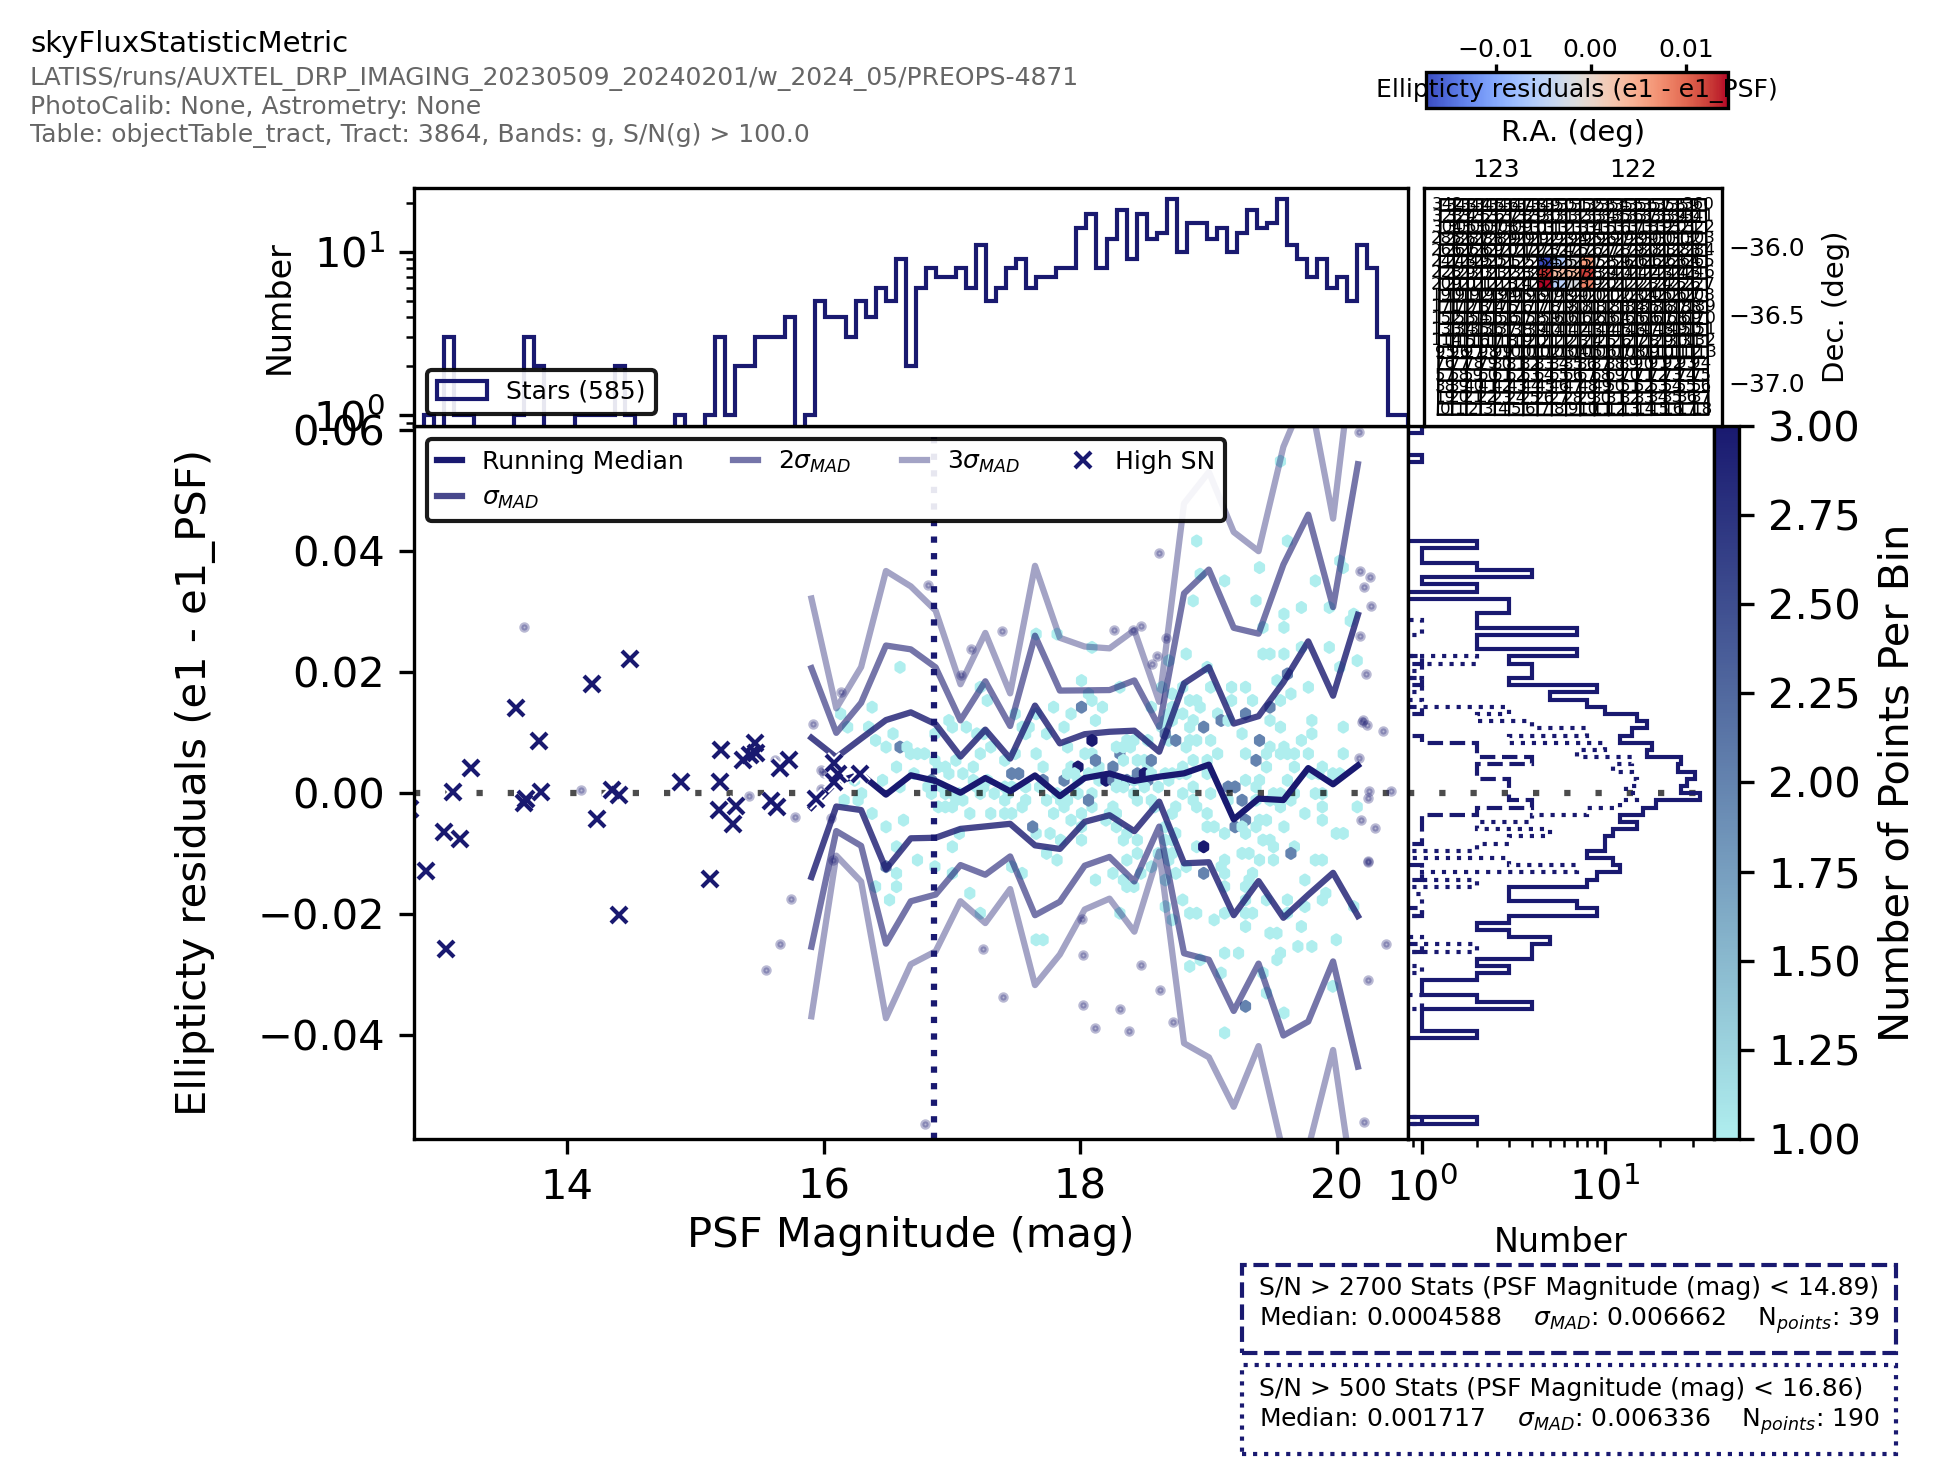

In [10]:
prep = taskState.atools.e1Diff.prep(inputData["data"], plotInfo=plotInfoDict, skymap=skymap, band=band_sel)
#print("Prep:", prep)
process = taskState.atools.e1Diff.process(prep, band=band_sel)
#print("Process:", process)
produce = taskState.atools.e1Diff.produce(process, band=band_sel, plotInfo=plotInfoDict, skymap=skymap)
#print("Produce:", produce)

Let's change something about the selectors and then re run the plot

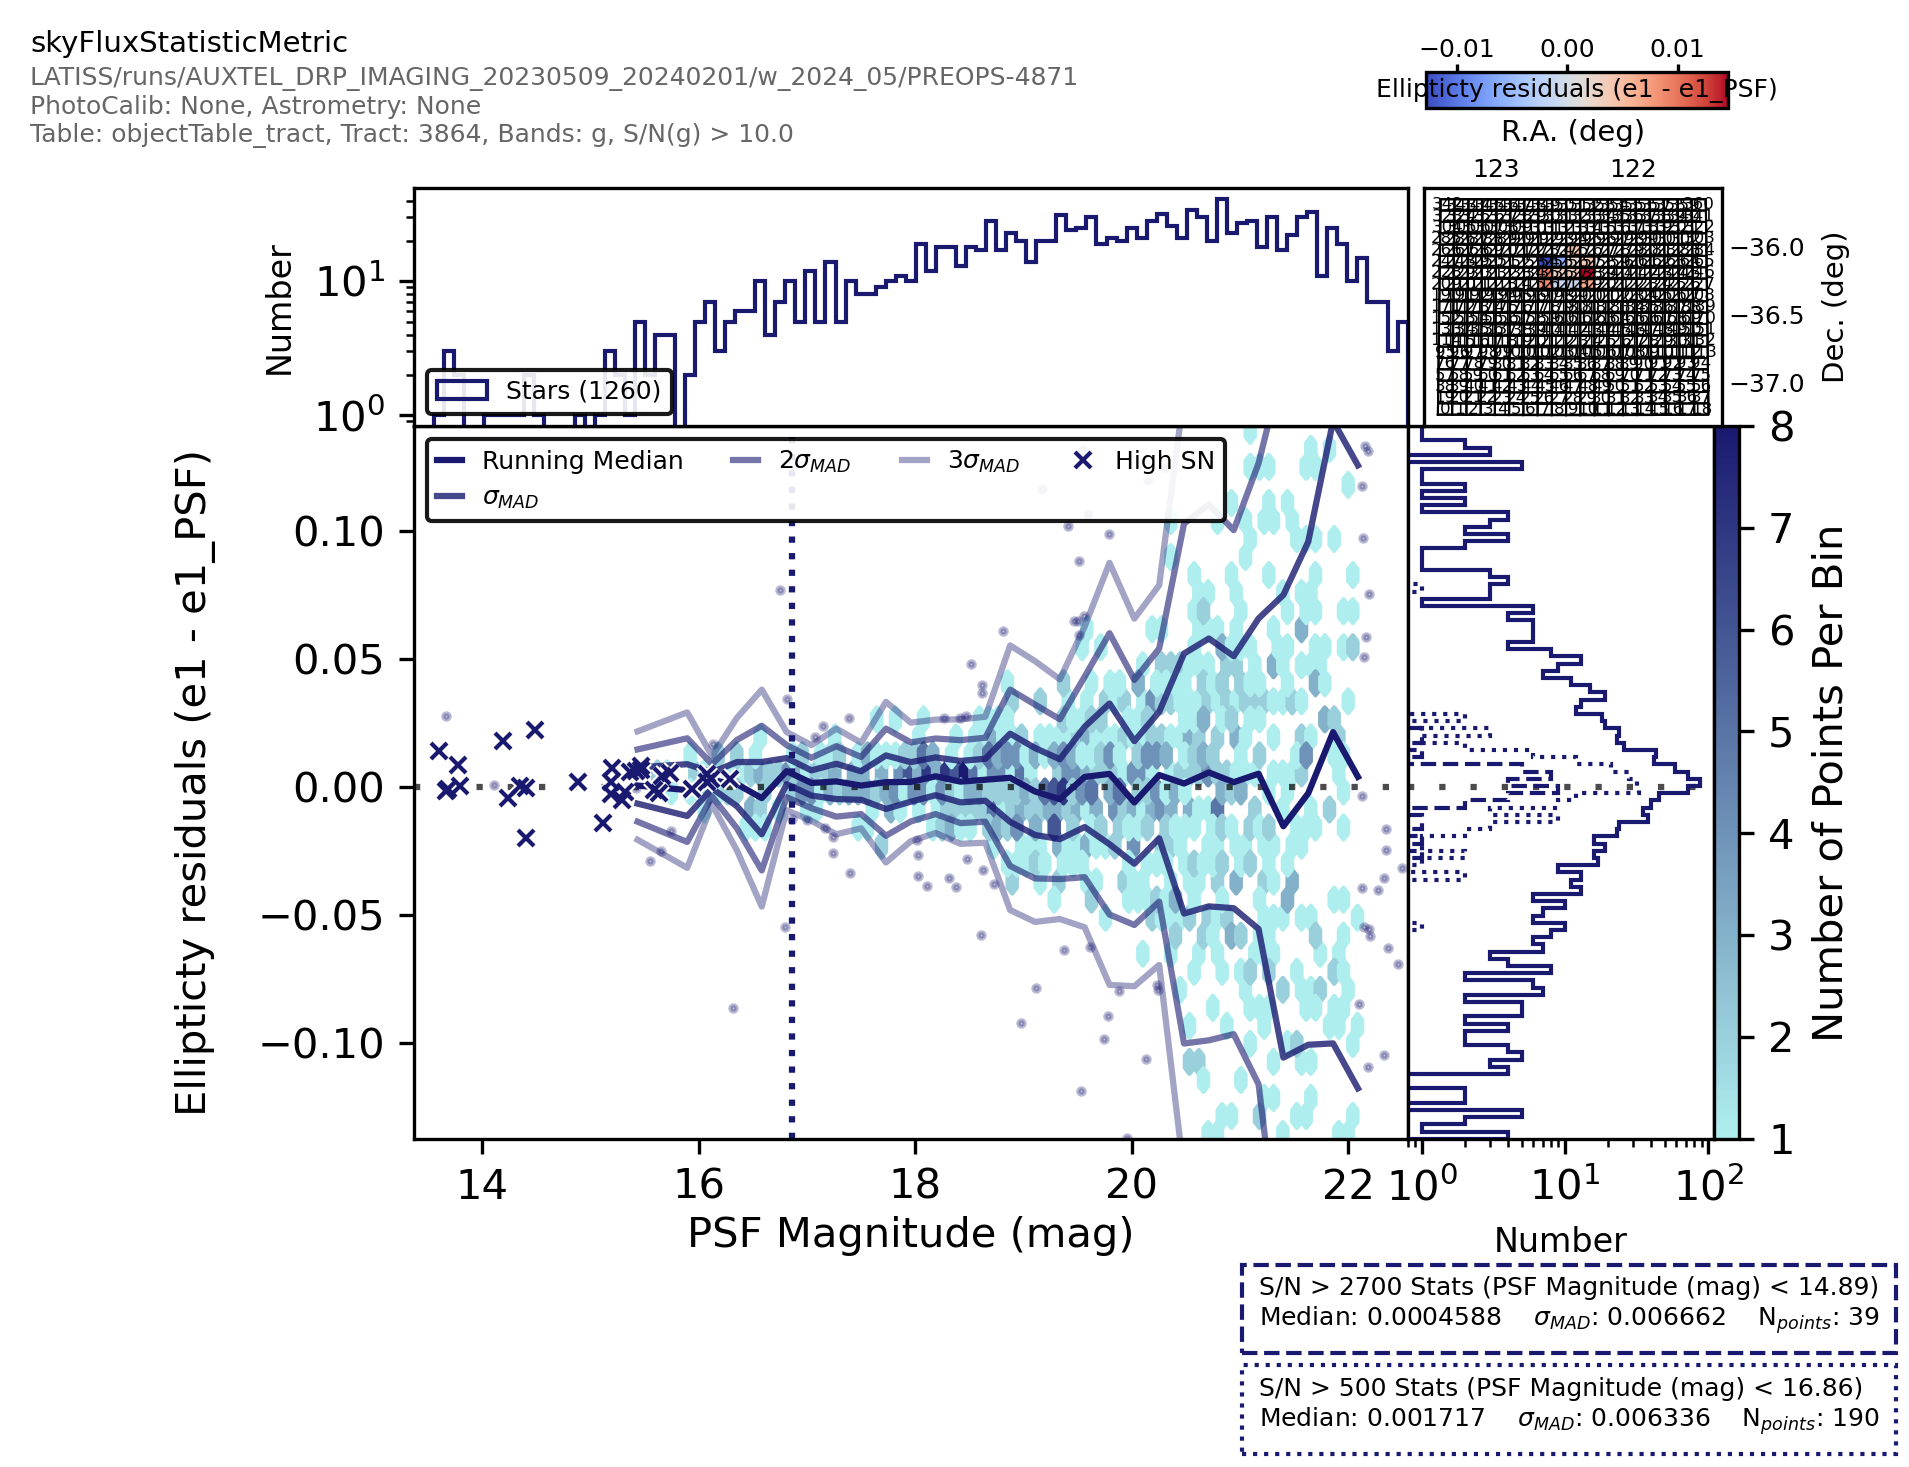

In [11]:
taskState.atools.e1Diff.prep.selectors.snSelector.threshold = 10
prep = taskState.atools.e1Diff.prep(inputData["data"], plotInfo=plotInfoDict, skymap=skymap, band=band_sel)
process = taskState.atools.e1Diff.process(prep, band=band_sel)
produce = taskState.atools.e1Diff.produce(process, band=band_sel, plotInfo=plotInfoDict, skymap=skymap)